# Gaussian Process on the concrete UCI dataset, using Inducing Points and all points

# Github

In [7]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/GPs


# Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
from sklearn.model_selection import train_test_split
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/concrete.ipynb # Run the concrete notebook which is in the datasets folder(concrete dataset)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^

# Training/Test data from concrete.ipynb

In [30]:
# Set a seed for reproducibility
np.random.seed(52)

concrete_data = df_Concrete # df_Concrete is defined in ../datasets/concrete.ipynb
x, y = concrete_data.iloc[:, :-1].to_numpy() , concrete_data.iloc[:, -1].to_numpy()  # The last column is output(concrete compressive strength)

# Split into training and validation datasets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1)
# Normalize training points
xTrain_mean = xTrain.mean(axis = 0) # mean for each feature
xTrain_std = xTrain.std(axis = 0) # std for each feature
yTrain_mean = yTrain.mean() # mean for output
yTrain_std = yTrain.std() # std for output
xTrain = (xTrain-xTrain_mean) / xTrain_std
yTrain = (yTrain-yTrain_mean) / yTrain_std

# Normalize test points
xTest_mean = xTest.mean(axis = 0) # mean for each feature
xTest_std = xTest.std(axis = 0) # std for each feature
yTest_mean = yTest.mean() # mean for output
yTest_std = yTest.std() # std for output
xTest = (xTest-xTest_mean) / xTest_std
yTest = (yTest-yTest_mean) / yTest_std

# Convert them to tensors
xTrain = torch.from_numpy(xTrain).float()
yTrain = torch.from_numpy(yTrain).float()

xTest = torch.from_numpy(xTest).float()
yTest = torch.from_numpy(yTest).float()

print(xTrain.size(), yTrain.size(), xTest.size(), yTest.size())

torch.Size([927, 8]) torch.Size([927]) torch.Size([103, 8]) torch.Size([103])


# The GP model

In [31]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(GPModel, self).__init__(x, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [32]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain, yTrain, likelihood) # Use training points and given likelihood
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Training Function

In [33]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain

  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 150


  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()


# Train the Model#

In [34]:
%time train(model, xTrain, yTrain)

CPU times: user 12 s, sys: 658 ms, total: 12.7 s
Wall time: 12.9 s


# The posterior mean, variance and Covariance Matrix

In [35]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([103])

Variance Dimension:  torch.Size([103])

CovMatrix Dimension  torch.Size([103, 103])


# Predictive Distribution

In [36]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(f_preds)# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean = observed_pred.mean.numpy()

# Compute Root Mean Square Error (RMSE)

In [37]:
squared_error = (mean - yTest.numpy())**2 # Compute the squared error

mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

root_MSE

0.3418556707765516

# Check for Overfitting, (RMSE of training data)

In [38]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred_train = likelihood(model(xTrain))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean_train = observed_pred_train.mean.numpy()

squared_error_train = (mean_train - yTrain.numpy())**2 # Compute the squared error

mean_SE_train = squared_error_train.mean() # Compute the mean squared error

root_MSE_train = math.sqrt(mean_SE_train) # Compute the square root of the mean squared error

root_MSE_train

0.15851291889195188

# Compare different amount of points

In [39]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPoints(listOfPoints):
  timeList = []
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    inducingPointsX = torch.tensor(x[:points]) # Choose how many points to pick
    inducingPointsY = torch.tensor(y[:points]) # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print()
    print("Inducing Points: ", points)

    time = %timeit -o train(model, inducingPointsX, inducingPointsY) # Train the model
    timeList.append(time.all_runs) # Add mean time of all runs for current amount of points
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()
  return timeList
timeList = severalInducingPoints([10,50,100,200,300,400,500,600,700,900])



Inducing Points:  10
546 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  50
661 ms ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  100
916 ms ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  200
1.54 s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  300
2.68 s ± 434 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  400
4.75 s ± 528 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  500
8.01 s ± 1.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  600
12.4 s ± 955 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  700
18.7 s ± 1.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  900
12.8 s ± 1.57 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot The Different Times

([<matplotlib.axis.XTick at 0x7ae71a6ff6a0>,
 [Text(1, 0, '100'),
  Text(2, 0, '200'),
  Text(3, 0, '300'),
  Text(4, 0, '400'),
  Text(5, 0, '500'),
  Text(6, 0, '600'),
  Text(7, 0, '700'),
  Text(8, 0, '800'),
  Text(9, 0, '900')])

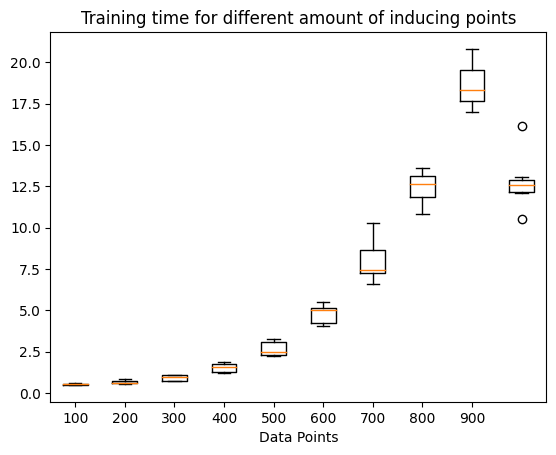

In [40]:
plt.title('Training time for different amount of inducing points')
plt.xlabel('Data Points')

plt.boxplot(timeList)
plt.xticks([1,2,3,4,5,6,7,8,9],[100,200,300,400,500,600,700,800,900])

# Inducing points with K-means

#K-means

In [43]:
def kmeansPoints(x, y, N): # The dataset (X,Y) and the N amount of inducing points wished
  RS = 0 # Random state
  xTrain_KMeans = x
  kmeans = KMeans(n_clusters=N, n_init=10, random_state=RS ).fit(xTrain_KMeans)# Apply K-means clustering on the training data
  xInducing = kmeans.cluster_centers_ # Use the centers of the clusters as the inducing points
  # To get the corresponding y values for each inducing point, compute the closest data point.
  closest_indices, _ = pairwise_distances_argmin_min(xInducing, xTrain_KMeans) # Will return indexes of xTrain_KMeans which is most similar(the same in this case) as xInducing
  yInducing = y[closest_indices] # Choose the corresponding y values for the inducing points
  return torch.from_numpy(xInducing), yInducing

# Compare different amount of inducing points
## Speed and performance

In [47]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPointsKmeans(listOfPoints):
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    print()
    print("---Inducing Points: ---", points)
    print("K-means: ")
    inducingPointsX, inducingPointsY = %time kmeansPoints(xTrain, yTrain, points) # Choose how many points to pick
    print()
    inducingPointsX = inducingPointsX.float()
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print("Training: ")
    %time train(model, inducingPointsX, inducingPointsY) # Train the model
    print()
    # Performance
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
      print("Prediction distribution: ")
      observed_pred = %time likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
      print()
      mean = observed_pred.mean.numpy()

    squared_error = (mean - yTest.numpy())**2 # Compute the squared error
    mean_SE = squared_error.mean() # Compute the mean squared error
    root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error
    print("RMSE: ",root_MSE)


severalInducingPointsKmeans([10,50,100,200,300,400,500,600,700,900])


---Inducing Points: --- 10
K-means: 
CPU times: user 80.7 ms, sys: 1.96 ms, total: 82.7 ms
Wall time: 273 ms

Training: 
CPU times: user 550 ms, sys: 7.03 ms, total: 557 ms
Wall time: 678 ms

Prediction distribution: 
CPU times: user 4.46 ms, sys: 0 ns, total: 4.46 ms
Wall time: 4.45 ms

RMSE:  0.8012936697142028

---Inducing Points: --- 50
K-means: 
CPU times: user 133 ms, sys: 1.01 ms, total: 134 ms
Wall time: 133 ms

Training: 
CPU times: user 529 ms, sys: 2.86 ms, total: 532 ms
Wall time: 546 ms

Prediction distribution: 
CPU times: user 6.99 ms, sys: 0 ns, total: 6.99 ms
Wall time: 6.84 ms

RMSE:  0.6939434975907148

---Inducing Points: --- 100
K-means: 
CPU times: user 264 ms, sys: 4.06 ms, total: 268 ms
Wall time: 271 ms

Training: 
CPU times: user 607 ms, sys: 8.94 ms, total: 616 ms
Wall time: 620 ms

Prediction distribution: 
CPU times: user 6.48 ms, sys: 0 ns, total: 6.48 ms
Wall time: 6.37 ms

RMSE:  0.6323665177620363

---Inducing Points: --- 200
K-means: 
CPU times: user 

<ipython-input-43-5e30f2898f4b>:4: ConvergenceWarning: Number of distinct clusters (896) found smaller than n_clusters (900). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=N, n_init=10, random_state=RS ).fit(xTrain_KMeans)# Apply K-means clustering on the training data


CPU times: user 14.8 s, sys: 35.3 ms, total: 14.8 s
Wall time: 15 s

Training: 
CPU times: user 8.75 s, sys: 25.6 ms, total: 8.78 s
Wall time: 8.78 s

Prediction distribution: 
CPU times: user 129 ms, sys: 1 ms, total: 130 ms
Wall time: 130 ms

RMSE:  0.3472052123618724
